In [1]:
import pandas as pd
import numpy as np
import glob
import re
import random
import types
import multiprocessing
import sys 
sys.path.append("../")
from multiprocessing import Pool
import matplotlib.pyplot as plt
from scipy import interpolate
from tqdm.notebook import tqdm

# io_f, compute_fはコンペのgithubから持ってきたファイル
from src.io_f import read_data_file
import src.compute_f as compute_f


In [2]:
def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val
        # functions / callables
        if hasattr(val, '__call__'):
            yield name, val
np.seterr(divide='ignore', invalid='ignore')
noglobal = lambda fn: types.FunctionType(fn.__code__, dict(imports()))

In [3]:
# testで予測するサイトを見てみる
# dictionary used to map the floor codes to the values used in the submission file. 
floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2, "F4":3, "F5":4, "F6":5, "F7":6,"F8":7, "F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5, "7F":6, "8F": 7, "9F":8}
            
base_path = '../input/indoor-location-navigation/'
sample_submission = pd.read_csv(base_path + 'sample_submission.csv')
used_buildings = sample_submission['site_path_timestamp'].str.split('_', expand=True)[0].unique()

## サンプルを取得

In [4]:
sample = []
p = 0.01
for building in tqdm(used_buildings):
    folders = sorted(glob.glob(os.path.join(base_path,'train/'+building+'/*')))
    wifi = list()
    for folder in folders:
        floor = floor_map[folder.split('/')[-1]]
        files = glob.glob(os.path.join(folder, "*.txt"))
        for file in files:
            if p > random.random():
                sample.append(file)
                break
        break 

In [96]:
# 予測対象のサイトのサンプルを取得する
# ../input/indoor-location-navigation/train/5da1389e4db8ce0c98bd0547/B1/5dc52af521dceb00061148d3.txt
path_file = sample[5]
print(path_file)
example = read_data_file(path_file)

../input/indoor-location-navigation/train/5da1389e4db8ce0c98bd0547/B1/5dc52af521dceb00061148d3.txt


In [97]:
trajectory = example.waypoint
trajectory_timestamp = trajectory[:,0]
trajectory_waypoint = trajectory[:, 1:]
x_observed = trajectory_waypoint[:, 0]
y_observed = trajectory_waypoint[:, 1]

wifi = example.wifi
wifi_timestamp = wifi[:, 0].astype(int)
wifi_last_seen_timestamp = wifi[:, -1].astype(int) # last seen
time_diff =  wifi_timestamp -wifi_last_seen_timestamp

In [98]:
len(time_diff)

2396

(array([423., 253., 196.,  51., 133.,  71.,  41.,  83.,  56.,  37.,  63.,
         40.,  45.,  46.,  34.,  50.,  19.,  49.,  44.,   9.,  37.,  30.,
         26.,  40.,  29.,  22.,  33.,  19.,  30.,  25.,  16.,  34.,   8.,
         29.,  26.,   7.,  27.,  20.,  13.,  25.,  17.,  14.,  24.,  10.,
         17.,  14.,  15.,  19.,   4.,  23.]),
 array([  163.  ,   759.34,  1355.68,  1952.02,  2548.36,  3144.7 ,
         3741.04,  4337.38,  4933.72,  5530.06,  6126.4 ,  6722.74,
         7319.08,  7915.42,  8511.76,  9108.1 ,  9704.44, 10300.78,
        10897.12, 11493.46, 12089.8 , 12686.14, 13282.48, 13878.82,
        14475.16, 15071.5 , 15667.84, 16264.18, 16860.52, 17456.86,
        18053.2 , 18649.54, 19245.88, 19842.22, 20438.56, 21034.9 ,
        21631.24, 22227.58, 22823.92, 23420.26, 24016.6 , 24612.94,
        25209.28, 25805.62, 26401.96, 26998.3 , 27594.64, 28190.98,
        28787.32, 29383.66, 29980.  ]),
 <BarContainer object of 50 artists>)

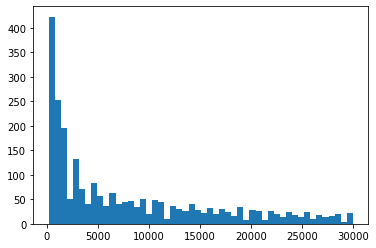

In [99]:
plt.hist(time_diff, bins=50)

## 線形補完によりwifiのwaypointを取得
非線形も含まれるだろうがここでは全て線形補完とする

線形補完の問題点としてそのまま補完をしようとするとxが小さい値から大きい値を進行方向とみなし補完してしまう。  
これは意図するところではないので各step単位で補完する必要がある。ちょっと面倒なので一旦スルー。

In [100]:
@noglobal
def wifi_waypoint_by_linear_interpolation(
        trajectory_timestamp, wifi_timestamp,
        x_observed, y_observed, delta_time,
        ): 

    wifi_waypoint_list = []
    wifi_text_list = []
    num_interpolation = len(trajectory_timestamp) - 1  # 補完回数 
    # 各waypoint間で線形補完
    for i in range(num_interpolation):
        # 潜在的なtimestampを作成(これのどれかにwifiを当てはめるような形)
        n_split = int((max(trajectory_timestamp[i:i+2]) - min(trajectory_timestamp[i:i+2])) / delta_time) + 2  # delta_time刻みとなるように分割数を指定(+2は始点と終点分)
        timestamp_latent = np.linspace(min(trajectory_timestamp[i:i+2]), max(trajectory_timestamp[i:i+2]), n_split).astype(int) 
        
        # xが昇順の場合はlatentも昇順になるようにする
        if x_observed[i] < x_observed[i+1]:
            x_latent = np.linspace(min(x_observed[i:i+2]), max(x_observed[i:i+2]), n_split)
        # xが降順の場合はlatentも降順になるようにする
        else:
            x_latent = np.linspace(min(x_observed[i:i+2]), max(x_observed[i:i+2]), n_split)[::-1]
        
        # 線形補完関数の適用
        fitted_curve = interpolate.interp1d(x_observed[i:i+2], y_observed[i:i+2])

        # wifiのtimestampに最も近いものをsplit_timestampから取得しそれに対応するwaypointをwifiのwaypointとして取得
        wifi_x = []
        wifi_y = []
        new_wifi_timestamp = []

        # 区間内のwifiデータのみ考える
        if i == 0:  # (始点のwaypointより早いtimestampもあるのでそれを含む)
            target_idx = wifi_timestamp < max(trajectory_timestamp[i:i+2])
        else:
            target_idx = (min(trajectory_timestamp[i:i+2]) < wifi_timestamp) & (wifi_timestamp < max(trajectory_timestamp[i:i+2]))
        target_wifi_timestamp = wifi_timestamp[target_idx]
        # timestampが最も近いものをwifiのwaypointとして取得
        print(len(target_wifi_timestamp))
        for t in target_wifi_timestamp:
            idx = np.abs(timestamp_latent - t).argmin()  # wifiデータとtimestampが最も近いものをlatentから取得
            if x_latent[idx] in wifi_x:
                pass
            else:
                wifi_x.append(x_latent[idx])
                wifi_y.append(fitted_curve(x_latent[idx]))
                new_wifi_timestamp.append(np.round((timestamp_latent[idx] - trajectory_timestamp[0]) / 1000, 1))


        wifi_waypoint = np.stack([wifi_x, wifi_y], axis=1)
        wifi_waypoint_list.append(wifi_waypoint)

        wifi_text_list.append([str(t) for t in new_wifi_timestamp])  

    wifi_waypoint = np.concatenate(wifi_waypoint_list)
    wifi_text = np.concatenate(wifi_text_list)
    return wifi_waypoint, wifi_text

In [101]:
# 前処理
THRESHOLD_TIME_DIFF = 5000  # 5s以上離れているlast seen は使用しない(どう決定すればいい?)

print(len(np.unique(wifi_last_seen_timestamp)))
wifi_target_timestamp = np.unique(wifi_last_seen_timestamp[time_diff < THRESHOLD_TIME_DIFF])  # 閾値より小さいwifiデータのみ使用

DELTA_TIME = 1000  # 1sごとにlast seen timestampをまとめる
bins = int((trajectory_timestamp.max() - trajectory_timestamp.min()) / DELTA_TIME)  # delta_time刻みとなるように分割数を指定
print(bins)
wifi_target_timestamp = np.linspace(min(wifi_target_timestamp), max(wifi_target_timestamp), bins)
# wifi_target_timestamp = np.linspace(min(wifi_last_seen_timestamp), max(wifi_last_seen_timestamp), bins)
print(len(wifi_target_timestamp))

966
49
49


In [110]:
wifi_target_timestamp

array([1.57320238e+12, 1.57320238e+12, 1.57320239e+12, 1.57320239e+12,
       1.57320239e+12, 1.57320239e+12, 1.57320239e+12, 1.57320239e+12,
       1.57320239e+12, 1.57320239e+12, 1.57320239e+12, 1.57320239e+12,
       1.57320240e+12, 1.57320240e+12, 1.57320240e+12, 1.57320240e+12,
       1.57320240e+12, 1.57320240e+12, 1.57320240e+12, 1.57320240e+12,
       1.57320240e+12, 1.57320240e+12, 1.57320241e+12, 1.57320241e+12,
       1.57320241e+12, 1.57320241e+12, 1.57320241e+12, 1.57320241e+12,
       1.57320241e+12, 1.57320241e+12, 1.57320241e+12, 1.57320242e+12,
       1.57320242e+12, 1.57320242e+12, 1.57320242e+12, 1.57320242e+12,
       1.57320242e+12, 1.57320242e+12, 1.57320242e+12, 1.57320242e+12,
       1.57320242e+12, 1.57320243e+12, 1.57320243e+12, 1.57320243e+12,
       1.57320243e+12, 1.57320243e+12, 1.57320243e+12, 1.57320243e+12,
       1.57320243e+12])

In [111]:
wifi_timestamp

array([1573202385113, 1573202385113, 1573202385113, ..., 1573202432967,
       1573202432967, 1573202432967])

In [112]:
wifi_waypoint, wifi_text = wifi_waypoint_by_linear_interpolation(
        trajectory_timestamp, wifi_timestamp,
        x_observed, y_observed, delta_time=100)  # delta_timeは細かい分には問題ないので0.1sとしている

60
313
274
298
209
210
305
287
440


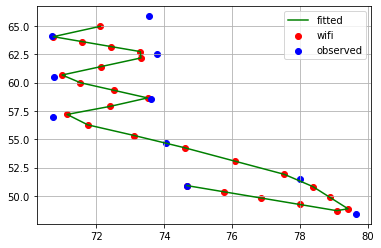

In [113]:
x_wifi = wifi_waypoint[:,0]
y_wifi = wifi_waypoint[:,1]
plt.plot(x_wifi, y_wifi, c="green", label="fitted")
plt.scatter(x_wifi, y_wifi, label="wifi", c='red')  # waypoint
plt.scatter(x_observed, y_observed, label="observed", c='blue')
plt.grid()
plt.legend()
plt.show()

In [104]:
# githubで与えられている関数を一部変更して利用
import plotly.graph_objs as go
from PIL import Image
import plotly
@noglobal
def visualize_trajectory(
    trajectory_waypoint, trajectory_timestamp,  # 元から与えられているwaypointの情報
    wifi_waypoint, wifi_timestamp,   # 上で算出したwifiの情報
    floor_plan_filename, width_meter, height_meter, title=None, show=False):
    fig = go.Figure()

    # waypoint
    size_list = [10] * trajectory_waypoint.shape[0]
    color_list = ['rgba(235, 5, 5, 1)'] * trajectory_waypoint.shape[0]

    text_list = trajectory_timestamp       
    text_list[0] = f'Start Point: {str(text_list[0])}'
    text_list[-1] = f'End Point: {str(text_list[-1])}'

    fig.add_trace(
        go.Scattergl(
            x=trajectory_waypoint[:, 0],
            y=trajectory_waypoint[:, 1],
            mode='lines + markers + text',
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='rgba(235, 5, 5, 1)', width=2, dash='dot'),
            text=text_list,
            textposition="top center",
            name='trajectory',
        ))

    # wifi
    size_list = [7] * wifi_waypoint.shape[0]
    color_list = ['rgba(4, 174, 4, 0.5)'] * wifi_waypoint.shape[0]
    text_list = wifi_timestamp       

    fig.add_trace(
        go.Scattergl(
            x=wifi_waypoint[:, 0],
            y=wifi_waypoint[:, 1],
            mode='markers + text',
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='rgba(4, 174, 4, 0.5)', width=2, dash='dot'),
            text=text_list,
            textposition="top center",
            name='wifi',
        ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=900,
        height=200 + 900 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig   

In [105]:
# jsonデータとpngデータを取得
import json
site = path_file.split('/')[4]
floor = path_file.split('/')[-2]
floor_plan_filename = f'../input/indoor-location-navigation/metadata/{site}/{floor}/floor_image.png'
json_plan_filename = f'../input/indoor-location-navigation/metadata/{site}/{floor}/floor_info.json'

with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)
    
width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]

# Title
title = "Example of Waypoint"

In [106]:
# 地図中にtimestampを可視化させたいので文字列にする
# 可視化の際はUNIXだとわかりずらいのでスタート地点(trajectory_timestamp[0])を0秒として秒単位で表示
trajectory_text = [str(number) for number in np.round((trajectory_timestamp - trajectory_timestamp[0]) / 1000, 1)]


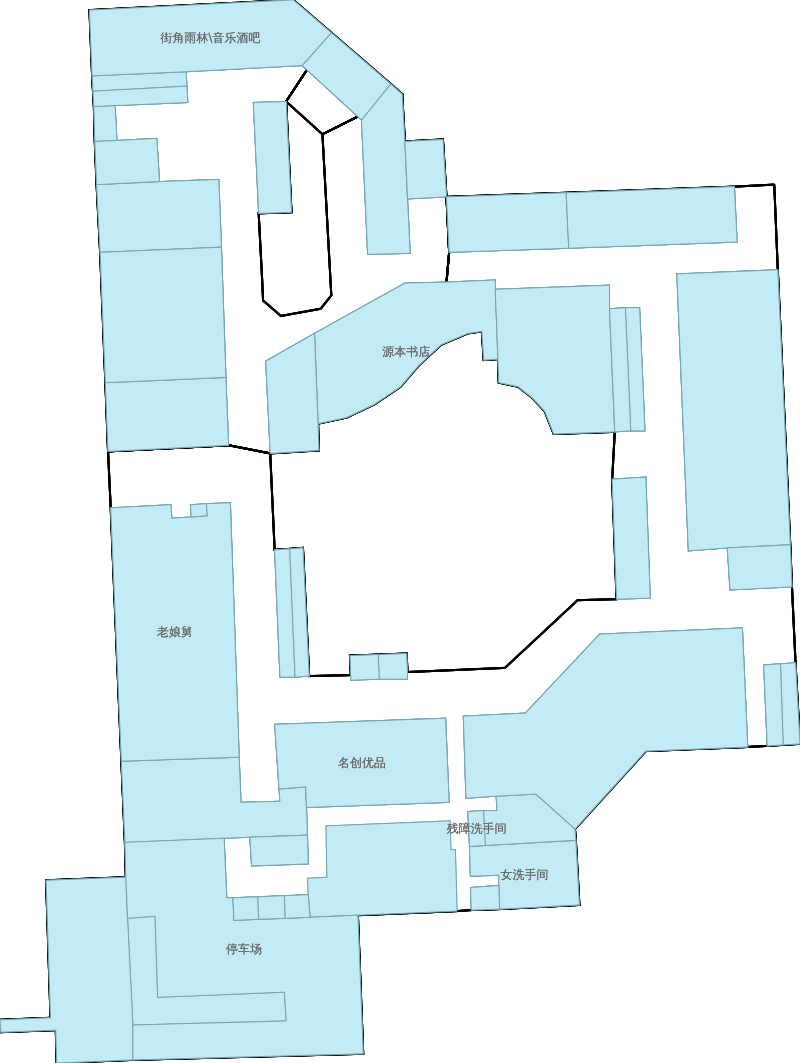

In [107]:
# Finally, let's plot
fig = visualize_trajectory(
                     trajectory_waypoint = trajectory_waypoint,
                     trajectory_timestamp = trajectory_text,
                     wifi_waypoint = wifi_waypoint,
                     wifi_timestamp = wifi_text,
                     floor_plan_filename = floor_plan_filename,
                     width_meter = width_meter,
                     height_meter = height_meter,
                     title = title,
                     show=True
                     )

In [109]:
# HTML化
plotly.offline.plot(fig, filename='graph.html')  # ファイル名

'graph.html'